In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
from helpers.helpers import set_size
import matplotlib.ticker as ticker
import statsmodels
import statsmodels.api as sm
import numpy as np
import seaborn as sns
df = pd.read_csv("./data/banned_final.csv")
df.banDate = pd.to_datetime(df.banDate)
df_att = pd.read_csv("./data/joined_final.csv")
df_att.value_date = pd.to_datetime(df_att.value_date)

# Example

2018-08-06T00:00:00.000000000
2018-09-06T00:00:00.000000000
2019-05-02T00:00:00.000000000
2020-01-31T00:00:00.000000000
2020-06-20T00:00:00.000000000


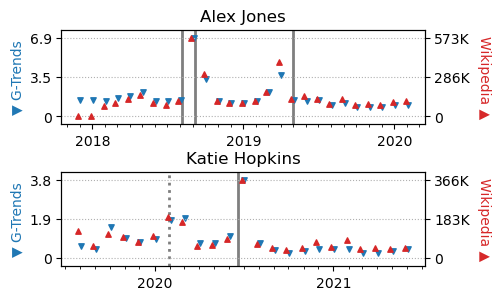

In [2]:
fs = (5, 3)
fig, axs = plt.subplots(2, 1, figsize=fs, gridspec_kw={"hspace": 0.5, "wspace": 0.5})
axs = axs.flatten()
for idx, entity, l, u in [(0, "Alex Jones", "November 2017", "February 2020"),
                          (1, "Katie Hopkins", "July 2019", "June 2021"),]:
    ax1 = axs[idx]
    ax2 = ax1.twinx()


    x1 = df_att[(df_att.entity == entity) & (df_att.source == "gtab")]\
        .groupby(pd.Grouper(key="value_date", freq="m")).value.sum()
    
    x1 = x1[x1.index.values >= pd.to_datetime(l)]
    x1 = x1[x1.index.values < pd.to_datetime(u)]
    x_ban = df[(df.entity == entity)]
    ax1.scatter([v + timedelta(days=3) for v in x1.index] , x1.values, marker="v", s=15, color="tab:blue")
#     ax1.plot(x1.rolling(3).mean(), color="tab:blue")

    x2 = df_att[(df_att.entity == entity) & (df_att.source == "wikimedia")]\
        .groupby(pd.Grouper(key="value_date", freq="m")).value.sum()
    x2 = x2[x2.index.values >= pd.to_datetime(l)]
    x2 = x2[x2.index.values < pd.to_datetime(u)]
    x_ban = df[(df.entity == entity)]
    ax2.scatter([v - timedelta(days=3) for v in x2.index], x2.values, marker="^", s=15, color="tab:red")
#     ax2.plot(x2.rolling(3).mean(), color="tab:red")
        
    for ax, x in zip([ax1, ax2], [x1, x2]):
        ax.set_ylim(0 - max(x)/10, max(x) + max(x)/10)
        ylim_ax = ax.get_ylim()
        ylim_ax_mid = (ylim_ax[1] + ylim_ax[0])/2
        ylim_ax_d = (0 - ylim_ax[0])
        ax.set_yticks([0, ylim_ax_mid, ylim_ax[1] - ylim_ax_d])
        
    def y_fmt(x, y):
        if x == 0:
            return "0"
        if x < 10:
            return '{:1.1f}'.format(round(x, 1))
        if x < 1000:
            return "{:.0f}".format(round(x))
        else:
            num = float('{:.3g}'.format(x))
            magnitude = 0
            while abs(num) >= 1000:
                magnitude += 1
                num /= 1000.0
            return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    ax1.set_ylabel("▼ G-Trends", color="tab:blue")
    ax2.set_ylabel("Wikipedia ▲", color="tab:red", rotation=270, labelpad=15)
    
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_minor_locator(mdates.MonthLocator())
    #     ax.plot(x.index, x.values, marker=".")
    #     ax.set_xlabel("Date")
    ax1.yaxis.grid(True, ls=":")
    flag = 1
    tmp__ = x_ban.drop_duplicates("bgid")
    for date, isTemp in zip(tmp__.banDate.values, tmp__.isTemporary.values):
        print(date)
        ax1.axvline(date, zorder=-3, color="tab:grey", lw=2, alpha=1, ls=":" if isTemp else "-",
                    label="Deplatforming" if flag == 1 else None)
        flag = 0

    #ax1.legend()
    ax1.set_title(entity)

set_size(fig, fs)
fig.savefig("./images/example.pdf", bbox_inches="tight")

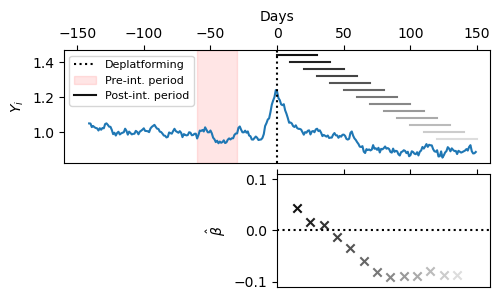

In [3]:
from scipy import signal
import numpy.random as random
fs = (5, 3)
random.seed(13)
fig, axs = plt.subplot_mosaic("AA;XD", figsize=(5, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.0})
fig.delaxes(axs["X"])

ax = axs["A"]
signal.unit_impulse(8)
ar1 = np.array([1, 0])
ma1 = np.array([1])
AR_object1 = sm.tsa.ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=300) / 10
x = np.arange(300)
simulated_data_1 += np.concatenate([np.ones(150), 0.8* np.ones(150)])
imp = signal.unit_impulse(160, 0)
b, a = signal.butter(1, 0.003)
response = np.concatenate([np.zeros(140), signal.lfilter(b, a, imp) * 30])

simulated_data_1 =  simulated_data_1 + response
f = pd.Series(simulated_data_1, index=x-150)
ax.plot(f.rolling(10).mean(), color="tab:blue")
ax.axvline(0, ls=":", color="black", label="Deplatforming")
ax.axvspan(-60, -30, alpha=0.1, color="red", label="Pre-int. period")

y = 1.44
col_helper = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "a", "b", "c", "d"]
ci = 0
for i in range(0, 121, 10):
    ax.plot([i, i+30], [y, y], color="#" + col_helper[ci]*6, zorder = 0,
           label = "Post-int. period" if i == 0 else None)
    y -= 0.04
    pre = f.loc[-60:-30].mean()
    pos =  f.loc[i:i+30].mean()

    axs["D"].scatter(i + 15, pos- pre, color="#" + col_helper[ci]*6, marker="x")
    ci += 1
axs["D"].axhline(0, ls=":", color="black")
axs["D"].set_ylim([-0.11, 0.11])
axs["D"].set_xlim([0, 160])
axs["A"].set_xlim([-160, 160])
axs["A"].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs["A"].set_xlabel("Days")
axs["A"].xaxis.set_label_position('top') 
axs["D"].tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)
axs["D"].set_ylabel(r'$\hat{\beta}$ ')
axs["A"].set_ylabel(r'$Y_i$')
axs["A"].legend(fontsize=8)
set_size(fig, fs)
fig.savefig("./images/example_methods.pdf", bbox_inches="tight")

# Gets data

In [4]:
import numpy as np


def get_data(months, df, df_att, is_first=True, second=False):
    def diff_month(d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month
    #get first ban of each person
    dff = df.sort_values("banDate", ascending=is_first)

    if second:
        tmp_ = df.groupby(["entity", "bgid"]).first().reset_index()
        tmp_ = tmp_.groupby(["entity"]).first().reset_index().bgid
        dff = dff[~dff.bgid.isin(tmp_)]
        dff = dff.drop_duplicates("entity", keep="first")
    else:
        dff = dff.drop_duplicates("entity", keep="first")


    dffm = dff.merge(df_att, left_on=["entity", "gid"], right_on=["entity", "google_id"])
    dffm["days_diff"] = (dffm["value_date"] - dffm["banDate"]).dt.days

    d1 = dffm["value_date"].dt
    d2 = dffm["banDate"].dt
    dffm["months_diff"] = diff_month(d1, d2)

    dffm = pd.concat([dffm[(dffm["source"] == "gtab") & (dffm["months_diff"].abs() <= months)],
    dffm[(dffm["source"] == "wikimedia") & (dffm["days_diff"].abs() <= 330)]]).reset_index(drop=True)

    dffm.loc[dffm.value == 0, "value"] =  0.00001
    dffm["logval"] = np.log(dffm["value"])
    dffm["is_banned"] = dffm["days_diff"] >= 0

    return dff, dffm

dff_last, dffm_last = get_data(14, df, df_att, is_first=False, second=False)
dff_first, dffm_first = get_data(14, df, df_att, is_first=True, second=False)
dff_second, dffm_second = get_data(14, df, df_att, is_first=False, second=False)


# General Panel OLS

In [5]:
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
def get_standard_error_sum(results, covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    # get the variance covariance matrix
    # print(covariates)
    vcov = results.cov \
        .loc[covariates, covariates].values

    # calculate the sum of all pair wise covariances by summing up off-diagonal entries
    off_dia_sum = np.sum(vcov)
    # variance of a sum of variables is the square root
    return np.sqrt(off_dia_sum)

def get_data_plots(diff, df, dff, dffm, formula, init_accs, update_accs, typ="wikimedia", retf=False):
    accs = init_accs()
    def diff_month(d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month
    if typ == "wikimedia":
        xs = list(range(0, 360 - diff + 1, 5))
    else:
        xs = list(range(0, 13, 1))
    for leftb in xs:
        is_valid = []
        for idx, row in dff.iterrows():
            row = dict(row)
            xx = df[
                (df.entity == row["entity"]) &
                (df.bgid != row["bgid"])]

            if len(xx) != 0:
                d1 = xx["banDate"]
                if typ == "wikimedia":
                    days_diff_ = (d1 - row["banDate"]).dt.days
                    xx = xx[(days_diff_ < leftb + diff) & (days_diff_ > -30 - diff)] 
                else:
                    months_diff_ = diff_month(d1.dt, row["banDate"])
                    xx = xx[(months_diff_ < leftb + diff) & (months_diff_ > - diff)] 
                             
            is_valid.append(len(xx)  == 0)
        
        #print(len(dff))
        valid_list  = dff.loc[is_valid].entity.values
        #print(len(valid_list))

        dfx = dffm[(dffm.source == typ) & (dffm.entity.isin(valid_list))]
        if typ == "wikimedia":
            dfx = dfx[dfx.days_diff.between(-30 - diff, -31) | dfx.days_diff.between(leftb,leftb + diff)]
        else:
            dfx = dfx[dfx.months_diff.between(- diff, -diff) | dfx.months_diff.between(leftb + diff, leftb + diff)]
                             
        dfxx = dfx.groupby(["entity", "is_banned", "isTemporary", "reason",
                           "platform", 'politician', 'media_personality',
                           'internet_personality', 'fringe_movements']).value.sum().reset_index()
        dfxx_ = dfxx.groupby("entity").value.count().reset_index()
        dfx = dfx[dfx.entity.isin(dfxx_[dfxx_.value == 2].entity.values)]

        dfx["logval"] = np.log(dfx.value)
        
        numeric_index = dfx.groupby("entity").is_banned.transform(lambda c: np.arange(len(c)))
        dfx["numeric_index"] = diff_month(dffm_last.value_date.dt, min(dffm_last.value_date))  # numeric_index
        mod = PanelOLS.from_formula(formula, dfx.set_index(["entity", "numeric_index"]), 
                                    drop_absorbed=True)
        res = mod.fit(cov_type='clustered', cluster_entity=True)

        accs = update_accs(leftb, len(set(dfxx.entity.values)), accs, res)
    
    if retf:
        return accs, dfx
    else:
        return accs

# Permanent vs. Temporary and First vs. Last

In [6]:
def init_accs():
    return {
        "xs": [],
        "es": [],
        "all": {
            "pest": [], 
            "uppb": [], 
            "lowb": []
        },
        "tmp": {
            "pest": [], 
            "uppb": [], 
            "lowb": []
        },
    }

def update_accs(xs, es, accs, res):
    pes_all = res.params["is_banned"]
    low_all, up_all = res.conf_int().loc["is_banned"].values
    pes_tmp = res.params["isTemporary:is_banned"] + res.params["is_banned"] 
    sd = (get_standard_error_sum(res, ["is_banned", "isTemporary:is_banned"]))
    low_tmp, up_tmp = pes_tmp - 1.96 * sd, pes_tmp + 1.96 * sd
    accs["xs"].append(xs),
    accs["es"].append(es),
    accs["all"]["pest"].append(pes_all)
    accs["all"]["uppb"].append(up_all)
    accs["all"]["lowb"].append(low_all)
    accs["tmp"]["pest"].append(pes_tmp)
    accs["tmp"]["uppb"].append(up_tmp)
    accs["tmp"]["lowb"].append(low_tmp)
    
    return accs


formula = """logval ~ is_banned + isTemporary:is_banned + EntityEffects"""

accs_first = get_data_plots(30, df, dff_first, dffm_first, formula, init_accs, update_accs, "wikimedia")
accs_last = get_data_plots(30, df, dff_last, dffm_last, formula, init_accs, update_accs, "wikimedia")
accs_firstg = get_data_plots(1, df, dff_first, dffm_first, formula, init_accs, update_accs, "gtab")
accs_lastg = get_data_plots(1, df, dff_last, dffm_last, formula, init_accs, update_accs, "gtab")
accs_secondg = get_data_plots(1, df, dff_second, dffm_second, formula, init_accs, update_accs, "gtab")


In [7]:
def update_accs(xs, es, accs, res):
    pes_all = res.params["is_banned"]
    low_all, up_all = res.conf_int().loc["is_banned"].values
    accs["xs"].append(xs),
    accs["es"].append(es),
    accs["all"]["pest"].append(pes_all)
    accs["all"]["uppb"].append(up_all)
    accs["all"]["lowb"].append(low_all)

    
    return accs

formula2 = """logval ~ is_banned + EntityEffects"""
accs_lasta = get_data_plots(30, df, dff_last, dffm_last, formula2, init_accs, update_accs, "wikimedia")
accs_lastga = get_data_plots(1, df, dff_last, dffm_last, formula2, init_accs, update_accs, "gtab")
accs_seconda = get_data_plots(30, df, dff_second, dffm_second, formula2, init_accs, update_accs, "wikimedia")
accs_secondga = get_data_plots(1, df, dff_second, dffm_second, formula2, init_accs, update_accs, "gtab")


# First vs. Last / Tmp vs. Permanent

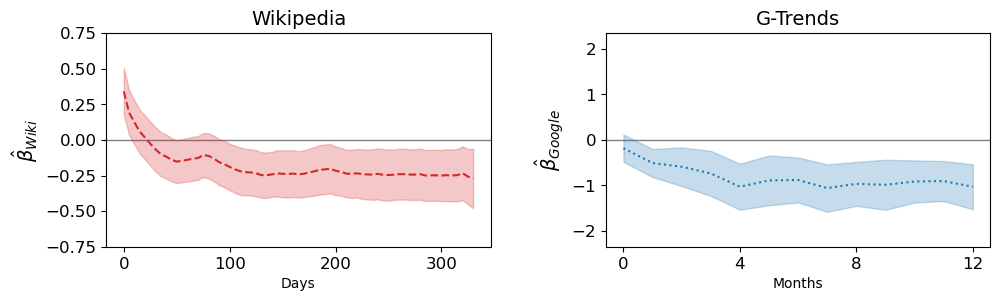

In [8]:
fs = (10, 3)
fig, axs = plt.subplots(1, 2,  figsize=fs, gridspec_kw={"hspace": 0.5, "wspace": 0.3})
axs = axs.flatten()

for ax, acc_top, acc_bot, title, ls, color, xlabel in zip(
    axs, 
    [accs_lasta, accs_lastga],
    [accs_lasta["all"], accs_lastga["all"]],
    [None] * 2,
    ["--", ":", "--", ":"],
    ["tab:red", "tab:blue"],
    ["Days", "Months"]
):

    ax.plot(acc_top["xs"], acc_bot["pest"], 
            alpha=1, color=color, zorder=1, ls=ls)
    ax.fill_between(acc_top["xs"], acc_bot["lowb"], acc_bot["uppb"],
                    alpha=0.25, color=color, zorder=-2)
    ax.axhline(0, zorder=-5, lw=1, color="black", alpha=0.5)
    ax.set_title(title, size=12)

    ax.set_xlabel(xlabel)
#     ax.yaxis.set_label_position("right")

axs[0].set_ylabel(r'$\hat{\beta}_{Wiki}$', size=14)
axs[1].set_ylabel(r'$\hat{\beta}_{Google}$', size=14)

axs[0].set_xticks([0, 100, 200, 300])
axs[1].set_xticks([0, 4, 8, 12])
axs[0].set_ylim([-0.75, 0.75])
axs[1].set_ylim([-2.35, 2.35])
axs[0].set_title("Wikipedia", size=14)
axs[1].set_title("G-Trends", size=14)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)

set_size(fig, fs)

fig.savefig("./images/me1.pdf", bbox_inches="tight")
# check grace period

325 -0.36947713966992307 -0.6436327266217339 -0.09532155271811232
11 -1.2037398812651088 -1.7920269738212742 -0.6154527887089435


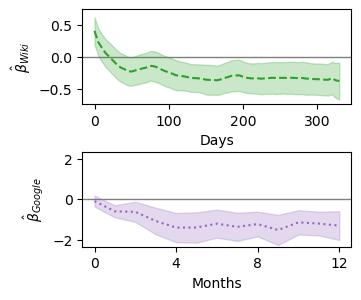

In [9]:
fs = (3.6, 3)
fig, axs = plt.subplots(2, 1,  figsize=fs, gridspec_kw={"hspace": 0.5, "wspace": 0.1}, sharey="row")
axs = axs.flatten()

for ax, acc_top, acc_bot, title, ls, color, xlabel in zip(
    axs, 
    [accs_last, accs_lastg],
    [accs_last["all"], accs_lastg["all"]],
    [None] * 2,
    ["--", ":", "--", ":"],
    ["tab:green", "tab:purple"],
    ["Days", "Months"]
):

    ax.plot(acc_top["xs"], acc_bot["pest"], 
            alpha=1, color=color, zorder=1, ls=ls)
    ax.fill_between(acc_top["xs"], acc_bot["lowb"], acc_bot["uppb"],
                    alpha=0.25, color=color, zorder=-2)
    ax.axhline(0, zorder=-5, lw=1, color="black", alpha=0.5)
    ax.set_title(title, size=12)

    ax.set_xlabel(xlabel)
    print(acc_top["xs"][-2], acc_bot["pest"][-2], acc_bot["lowb"][-2], acc_bot["uppb"][-2])
#     ax.yaxis.set_label_position("right")

axs[0].set_ylabel(r'$\hat{\beta}_{Wiki}$')
axs[1].set_ylabel(r'$\hat{\beta}_{Google}$')

axs[0].set_xticks([0, 100, 200, 300])
axs[1].set_xticks([0, 4, 8, 12])
axs[0].set_ylim([-0.75, 0.75])
axs[1].set_ylim([-2.35, 2.35])
set_size(fig, fs)

fig.savefig("./images/me2.pdf", bbox_inches="tight")


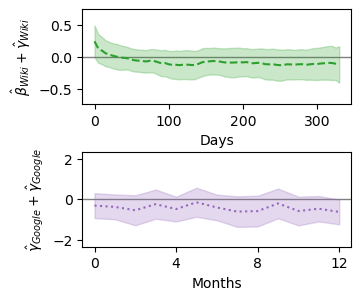

In [10]:
fs = (3.6, 3)
fig, axs = plt.subplots(2, 1,  figsize=fs, gridspec_kw={"hspace": 0.5, "wspace": 0.1}, sharey="row")
axs = axs.flatten()

for ax, acc_top, acc_bot, title, ls, color, xlabel in zip(
    axs, 
    [accs_last, accs_lastg],
    [accs_last["tmp"], accs_lastg["tmp"]],
    [None] * 2,
    ["--", ":", "--", ":"],
    ["tab:green", "tab:purple"],
    ["Days", "Months"]
):

    ax.plot(acc_top["xs"], acc_bot["pest"], 
            alpha=1, color=color, zorder=1, ls=ls)
    ax.fill_between(acc_top["xs"], acc_bot["lowb"], acc_bot["uppb"],
                    alpha=0.25, color=color, zorder=-2)
    ax.axhline(0, zorder=-5, lw=1, color="black", alpha=0.5)
    ax.set_title(title, size=12)

    ax.set_xlabel(xlabel)
#     ax.yaxis.set_label_position("right")

axs[0].set_ylabel(r'$\hat{\beta}_{Wiki} + \hat{\gamma}_{Wiki}$')
axs[1].set_ylabel(r'$\hat{\gamma}_{Google} + \hat{\gamma}_{Google}$')

axs[0].set_xticks([0, 100, 200, 300])
axs[1].set_xticks([0, 4, 8, 12])
axs[0].set_ylim([-0.75, 0.75])
axs[1].set_ylim([-2.35, 2.35])
set_size(fig, fs)

fig.savefig("./images/me3.pdf", bbox_inches="tight")
